In [2]:
import numpy as np
from tqdm.notebook import tqdm


def template_shape(slab, coord, size):
    return [(max(0, coord[i] - size // 2),
             min(slab.shape[i], coord[i] + size - size // 2))
            for i in range(len(slab.shape))]

def build_template(slab, coord, max_known_pixels=30):
    low, high = 5, 50
    (i_min, i_max), (j_min, j_max), (k_min, k_max) = template_shape(slab, coord, high)
    template = slab[i_min: i_max, j_min: j_max, k_min: k_max]

    if np.count_nonzero(template) <= max_known_pixels:
        return template.shape

    while high - low > 1:
        i = (low + high) // 2
        (i_min, i_max), (j_min, j_max), (k_min, k_max) = template_shape(slab, coord, i)
        template = slab[i_min: i_max, j_min: j_max, k_min: k_max]

        if np.count_nonzero(template) <= max_known_pixels:
            low = i
        else:
            high = i

    return template.shape
        


def simulate(slab):
    sim_sequence = np.argwhere(slab == 0)
    sim_sequence = np.random.permutation(sim_sequence)
    template_sizes = []
    for i, j, k in tqdm(sim_sequence):
        template_sizes.append(build_template(slab, (i, j, k), max_known_pixels=30))
        slab[i, j, k] = 1

    return np.array(template_sizes)


slab_ = np.zeros((100, 100, 30))

template_sizes = simulate(slab_)
# %timeit build_template(slab_)

  0%|          | 0/300000 [00:00<?, ?it/s]

In [43]:
import numpy as np
from scipy import fft as spfft


def slab_fft(slab):
    fft_shape = [spfft.next_fast_len(s, True) for s in slab.shape]
    fft_slab = spfft.rfftn(slab, fft_shape, workers=None)
    return fft_slab, fft_shape

def template_corr(fft_slab, fft_shape, template):
    # template_ = np.zeros(fft_shape, dtype=np.float32)
    fft_template = spfft.rfftn(template, fft_shape).conj()
    corr = spfft.irfftn(fft_slab * fft_template, fft_shape, workers=None).real
    return corr


def find_argmin(corr, min_distance=0):
    threshold = max(corr.min(), min_distance)
    inds = np.flatnonzero(corr <= threshold)
    random_ind = np.random.choice(inds)
    coord = np.unravel_index(random_ind, corr.shape)
    return coord    


slab_ = np.random.random((1000, 1000)).astype(np.float32)
template_ = np.random.random((30, 30)).astype(np.float32)


%timeit slab_fft(slab_)
fft_slab, fft_shape = slab_fft(slab_)
%timeit template_corr(fft_slab, fft_shape, template_)
corr = template_corr(fft_slab, fft_shape, template_)
%timeit find_argmin(corr)
%timeit fft_slab.conj()
%timeit spfft.rfftn(template_, fft_shape)

2.19 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.65 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
229 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
333 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.4 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
import tensorflow as tf

def slab_tf_fft(slab):
    fft_shape = [spfft.next_fast_len(s, True) for s in slab.shape]
    slab = tf.convert_to_tensor(slab, dtype=tf.float32)
    fft_slab = tf.signal.rfft3d(slab, fft_shape)
    return fft_slab, fft_shape


def template_tf_corr(fft_slab, fft_shape, template):
    template = tf.convert_to_tensor(template, dtype=tf.float32)
    fft_template = tf.math.conj(tf.signal.rfft3d(template, fft_shape))
    corr = tf.math.real(tf.signal.irfft3d(fft_slab * fft_template, fft_shape))
    return corr.numpy()


slab_ = np.random.random((100, 100, 100)).astype(np.float32)
template_ = np.random.random((30, 30, 30)).astype(np.float32)

# slab_tf = tf.convert_to_tensor(slab_, dtype=tf.float32)
# template_tf = tf.convert_to_tensor(template_, dtype=tf.float32)

%timeit slab_tf_fft(slab_)
fft_slab, fft_shape = slab_tf_fft(slab_)
%timeit template_tf_corr(fft_slab, fft_shape, template_)
%timeit tf.math.conj(fft_slab)

1.43 ms ± 51.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.08 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
250 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Continuous Variable Template Matching

(4, 8)


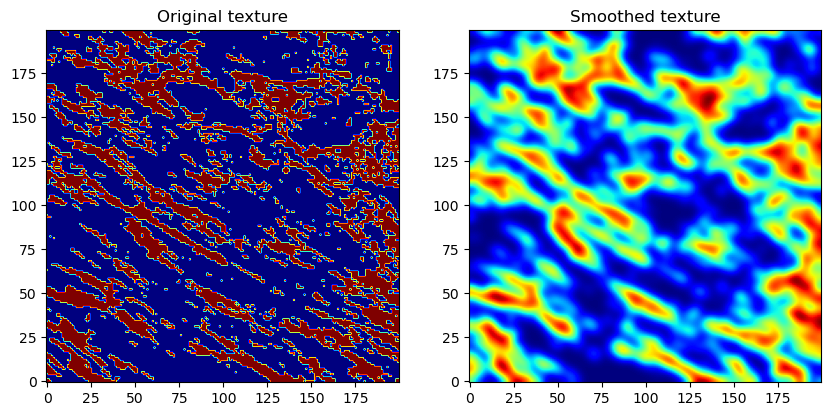

In [127]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

df = pd.read_csv(Path("/Users/arstanbek/Projects/fibrosis/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
df['Tissue size'] = df['Tissue size'].apply(
    lambda x: ast.literal_eval(x)
)

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]

print(filtered_df.shape)
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)

texture_smoothed = gaussian_filter(texture, sigma=3)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(texture, cmap='jet', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(texture_smoothed, cmap='jet', origin='lower')
axs[1].set_title('Smoothed texture')
plt.show()

100%|██████████| 40000/40000 [00:09<00:00, 4204.15it/s]


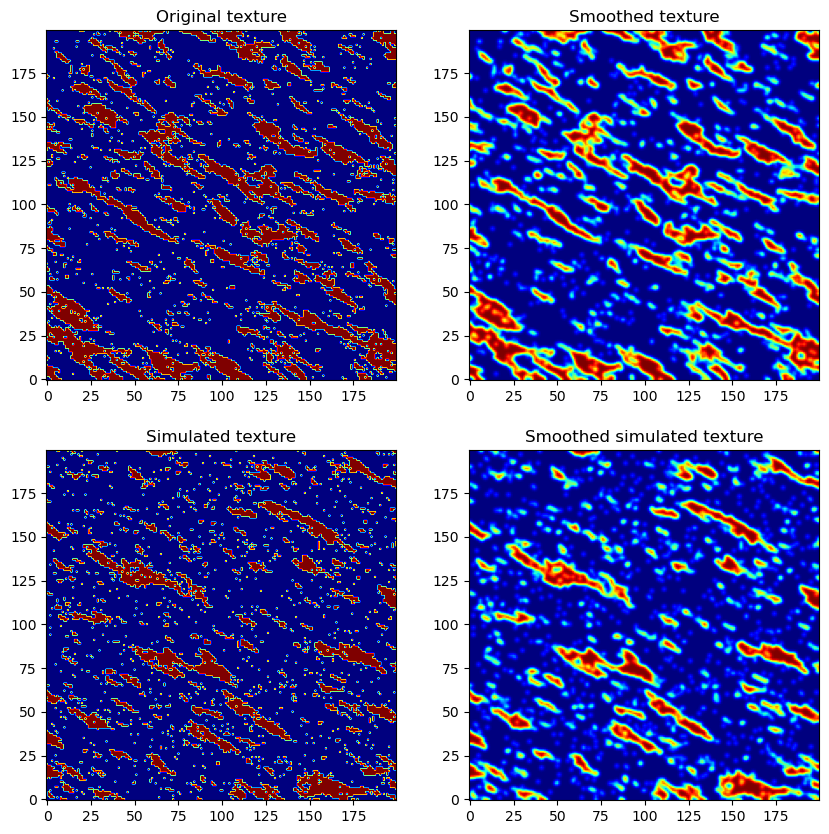

In [163]:
import bitis as bt

texture_ = texture[:, :].copy()
simulation_tex = np.zeros_like(texture_)

simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=5,
                                 num_of_candidates=1,
                                 min_known_pixels=1,
                                 use_tf=False)

simulated_tex = simulation.run(max_iter=None)

simulated_smoothed = gaussian_filter(simulated_tex, sigma=1)
texture_smoothed_ = gaussian_filter(texture_, sigma=1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(texture_, cmap='jet', origin='lower')
axs[0, 0].set_title('Original texture')
axs[0, 1].imshow(texture_smoothed_, cmap='jet', origin='lower')
axs[0, 1].set_title('Smoothed texture')
axs[1, 0].imshow(simulated_tex, cmap='jet', origin='lower')
axs[1, 0].set_title('Simulated texture')
axs[1, 1].imshow(simulated_smoothed, cmap='jet', origin='lower')
axs[1, 1].set_title('Smoothed simulated texture')
plt.show()

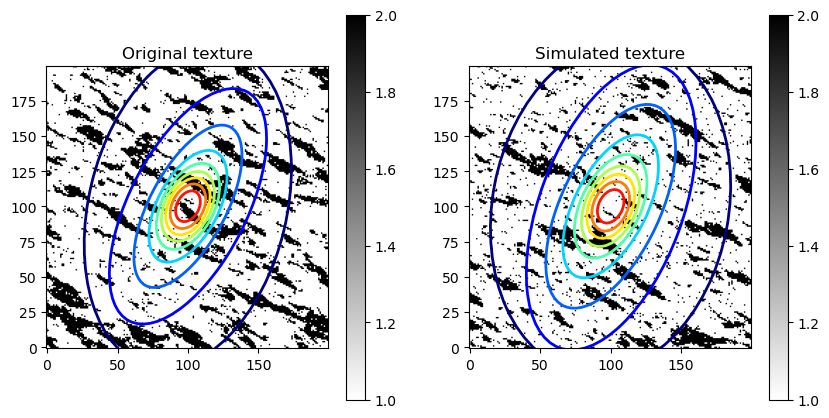

In [165]:
from scipy.ndimage import gaussian_filter
from skimage import measure
from matplotlib.patches import Ellipse


def calculate_power_spectrum(texture):
    texture_fft = np.fft.fftn(texture - texture.mean())
    texture_power = np.abs(texture_fft) ** 2
    texture_power = np.fft.fftshift(texture_power)
    return texture_power


def equivalent_ellipses(texture_power):
    ellipses = []
    for threshold in np.arange(0.1, 1.0, 0.1):
        texture_power = gaussian_filter(texture_power, sigma=4)
        sorted_idx = np.argsort(texture_power.ravel())
        cumsum = np.cumsum(texture_power.ravel()[sorted_idx])
        idx = sorted_idx[cumsum > cumsum[-1] * threshold]
        coords = np.unravel_index(idx, texture_power.shape)

        mask = np.zeros_like(texture_power, dtype=np.uint8)
        mask[tuple(coords)] = 1

        props = measure.regionprops(mask)
        short_axis = props[0].axis_minor_length
        long_axis = props[0].axis_major_length
        angle = props[0].orientation
        mean = props[0].centroid
        ellipses.append((mean, short_axis, long_axis, angle))
    return ellipses


tex_power = calculate_power_spectrum(texture)
sim_power = calculate_power_spectrum(simulated_tex)

sim_ellipses = equivalent_ellipses(sim_power)
tex_ellipses = equivalent_ellipses(tex_power)

cmap = plt.get_cmap('jet')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, tex, ellipses in zip(axs, [texture, simulated_tex],
                             [tex_ellipses, sim_ellipses]):
    cax = ax.imshow(tex, cmap='gray_r', origin='lower')
    # draw ellipses
    for i, (mean, w, h, angle) in enumerate(ellipses):
        ellipse = Ellipse(mean[::-1], w, h, angle=np.degrees(np.pi - angle),
                        fill=False, lw=2, edgecolor=cmap(i / len(ellipses)))
        ax.add_patch(ellipse)

    fig.colorbar(cax, ax=ax)
axs[0].set_title('Original texture')
axs[1].set_title('Simulated texture')
plt.show()

In [137]:
import numpy as np
from scipy.signal import fftconvolve


def direct_euclidean_distance(texture, template):
    distances = np.zeros((texture.shape[0] - template.shape[0] + 1,
                          texture.shape[1] - template.shape[1] + 1))
    for i in range(texture.shape[0] - template.shape[0] + 1):
        for j in range(texture.shape[1] - template.shape[1] + 1):
                distances[i, j] = np.sum((texture[i: i + template.shape[0],
                                                  j: j + template.shape[1]] - template)**2)
    return distances


def euclidean_distance(image, template):
    fft_im, fft_shape = slab_fft(image)
    fft_im2, _ = slab_fft(image ** 2)
    # im2_corr = template_corr(fft_im2, fft_shape, np.ones(template.shape, dtype=np.float32))
    # temp_corr = template_corr(fft_im, fft_shape, template)
    # return im2_corr - 2 * temp_corr + np.sum(template ** 2)

    fft_template = spfft.rfftn(template, fft_shape).conj()
    fft_ones = spfft.rfftn(np.ones(template.shape, dtype=np.float32), fft_shape).conj()
    fft_dist = fft_im2 * fft_ones - 2 * fft_im * fft_template
    temp_fft = spfft.irfftn(fft_dist, fft_shape).real
    return temp_fft + np.sum(template ** 2)


template = texture_smoothed[50:60, 50:60].copy()
# template[np.random.random(template.shape) < 0.5] = 0
edist = euclidean_distance(texture_smoothed, template)
# edist = squared_difference_fft(texture_smoothed, template)
ddist = direct_euclidean_distance(texture_smoothed, template)

edist = edist[:ddist.shape[0], :ddist.shape[1]]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
cax0 = axs[0].imshow(edist, cmap='jet', origin='lower')
axs[0].set_title('Euclidean distance')
fig.colorbar(cax0, ax=axs[0])
cax1 = axs[1].imshow(ddist, cmap='jet', origin='lower')
axs[1].set_title('Direct Euclidean distance')
fig.colorbar(cax1, ax=axs[1])
# cax2 = axs[2].imshow(edist - ddist, cmap='jet', origin='lower')
# axs[2].set_title('Difference')
cax2 = axs[2].imshow(texture_smoothed, cmap='jet', origin='lower')
axs[2].set_title('Texture')
fig.colorbar(cax2, ax=axs[2])
plt.show()

NameError: name 'slab_fft' is not defined

In [32]:
import bottleneck as bn

%timeit np.argpartition(edist.flat, 3)[:3]
%timeit bn.argpartition(edist.flat, 3)[:3]
%timeit find_n_min(edist, min_number=3)

20.9 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
26.3 µs ± 944 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
24.4 µs ± 1.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
x = np.random.random((100, 100, 100))

%timeit np.argpartition(x.ravel(), 10)[:10]
%timeit np.argpartition(x.flat, 10)[:10]

11.2 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


837 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
920 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
42.1 µs ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


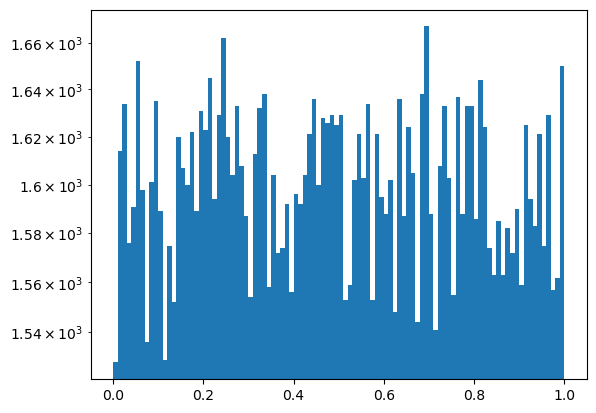

In [52]:
def find_n_min(edist, min_number=10):
    thr = np.partition(edist.flat, min_number)[:min_number]
    inds = np.flatnonzero(edist <= thr.max())
    inds = inds[np.argsort(edist.flat[inds])]
    return np.unravel_index(inds, edist.shape)


def find_n_min_2(edist, min_number=10):
    inds = np.argpartition(edist.flat, min_number)
    return np.unravel_index(inds[:min_number], edist.shape)

edist = np.random.random((400, 400))
inds = find_n_min(edist, min_number=10)

%timeit find_n_min(edist, min_number=10)
%timeit find_n_min_2(edist, min_number=10)
%timeit np.unravel_index(edist.argmin(), edist.shape)

plt.hist(edist.flatten(), bins=100)
plt.yscale('log')
plt.show()

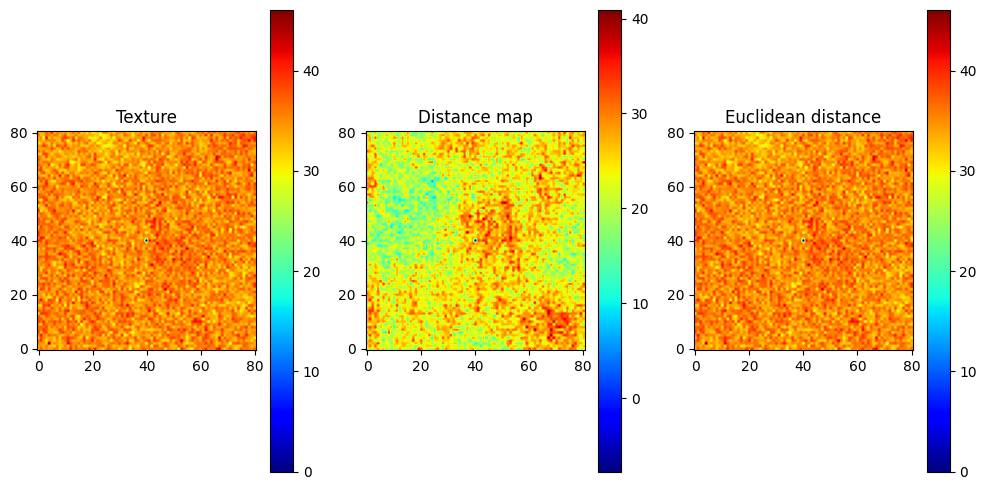

In [14]:
import numpy as np
import bitis as bt
import matplotlib.pyplot as plt
from scipy import fft as spfft


def direct_euclidean_distance(texture, template):
    distances = np.zeros((texture.shape[0] - template.shape[0] + 1,
                          texture.shape[1] - template.shape[1] + 1))
    for i in range(texture.shape[0] - template.shape[0] + 1):
        for j in range(texture.shape[1] - template.shape[1] + 1):
                diff = texture[i: i + template.shape[0],
                               j: j + template.shape[1]] - template
                distances[i, j] = np.sum(diff[template != 0]**2)
    return distances


def euclidean_distance(image, template):
    fft_shape = [spfft.next_fast_len(s, True) for s in image.shape]
    fft_im = spfft.rfftn(image, fft_shape)
    fft_im2 = spfft.rfftn(image ** 2, fft_shape)
    fft_template = spfft.rfftn(template, fft_shape).conj()
    fft_ones = spfft.rfftn((template != 0).astype(np.float32), fft_shape).conj()
    fft_dist = fft_im2 * fft_ones - 2 * fft_im * fft_template
    temp_fft = spfft.irfftn(fft_dist, fft_shape).real
    dist = temp_fft + np.sum(template ** 2)
    return dist[:image.shape[0] - template.shape[0] + 1,
                :image.shape[1] - template.shape[1] + 1]


texture = np.random.random((100, 100)).astype(np.float32)
template = texture[40:60, 40:60].copy()
template[np.random.random(template.shape) < 0.5] = 0

template_matcher = bt.ContinuousVariableMatching(texture)
dm = template_matcher.compute_distance_map(template)
edist = euclidean_distance(texture, template)
ddist = direct_euclidean_distance(texture, template)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

cax1 = axs[0].imshow(ddist, cmap='jet', origin='lower')
axs[0].set_title('Texture')
fig.colorbar(cax1, ax=axs[0])

cax0 = axs[1].imshow(dm, cmap='jet', origin='lower')
axs[1].set_title('Distance map')
fig.colorbar(cax0, ax=axs[1])

cax2 = axs[2].imshow(edist, cmap='jet', origin='lower')
axs[2].set_title('Euclidean distance')
fig.colorbar(cax2, ax=axs[2])

plt.tight_layout()
plt.show()